# Sentiment Analysis Between Communities

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import re

#### Load data, split post properties into columns, create networkx graphs

In [2]:
# load the data
network_file = "data/soc-redditHyperlinks-body.tsv"
political_file = "data/subreddits.txt"

df_full = pd.read_csv(network_file, sep="\t")

# separate post properties into different columns
post_colnames_df = pd.read_csv("post_properties_column_names.csv")
col_list = list(post_colnames_df['Colname'].values)
df_full[col_list] = df_full.loc[:,'PROPERTIES'].str.split(',', expand=True)
df_full[col_list] = df_full[col_list].astype(float) # correct datatype

## filter by political subreddits
# read in political subs
with open('data/subreddits.txt', 'r') as f:
    political_subs = f.readlines()
political_subs = [sub.rstrip('\n') for sub in political_subs]
regex = re.compile(r'(politic|trump|biden|democrat|republican|liberal|conservative|progressive|socialist|libertarian|election|vote|campaign|maga|antifa|obama|sanders|rights|reform|policy|government|senate|president)', re.IGNORECASE)
dynamic_political_subs = [sub for sub in df_full["SOURCE_SUBREDDIT"].unique() if regex.search(sub)]
political_subs.extend(dynamic_political_subs)

# filter dataframe 
source_is_political = df_full["SOURCE_SUBREDDIT"].isin(political_subs)
target_is_political = df_full["TARGET_SUBREDDIT"].isin(political_subs)

# keep only connections where both are political
df = df_full[source_is_political & target_is_political]
df_psource = df_full[source_is_political]
df_ptarget = df_full[target_is_political]

# create graphs
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()
edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
# add link sentiments
df_counts = df.groupby([source, target])['LINK_SENTIMENT'].value_counts().reset_index()
links = df_counts.groupby(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', 'LINK_SENTIMENT'])['count'].sum().unstack(fill_value=0).reset_index().rename(columns={1: 'POSITIVE', -1: 'NEGATIVE'})
edgelist_df = edgelist_df.merge(links, how='inner', on=[source,target])
edgelist_df["LINK_SENTIMENT"] = edgelist_df["POSITIVE"] - edgelist_df["NEGATIVE"]
G_directed = nx.from_pandas_edgelist(edgelist_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count", "POSITIVE", "NEGATIVE", "LINK_SENTIMENT"])
G_undirected = G_directed.to_undirected()

In [31]:
len(political_subs)

1088

#### Use Louvain Community Detection

In [3]:
# Compute the best partition
# partition = community_louvain.best_partition(G_undirected, weight='count')
def best_louvain_partition(G):

    best_modularity = -1
    best_partition = None
    for i in range(50):
        partition = community_louvain.best_partition(G, weight='count', random_state=i)
        modularity_value = community_louvain.modularity(partition, G)
        if modularity_value > best_modularity:
            best_modularity = modularity_value
            best_partition = partition
    return best_partition

partition = best_louvain_partition(G_undirected) 

nx.set_node_attributes(G_undirected, partition, 'community')
nx.set_node_attributes(G_directed, partition, 'community')

# transform to list of community sets
partition_df = pd.DataFrame({'subreddit': partition.keys(), 'community':partition.values()})
communities = partition_df.groupby(by='community').agg(set)['subreddit'].tolist()

# Select the top three nodes with the highest degree in each community for labeling
community_labels = {}
for community in set(partition.values()):
    community_nodes = [node for node in partition if partition[node] == community]
    
    top_nodes = sorted(community_nodes, key=lambda node: G_undirected.degree(node), reverse=True)[:3]

    community_labels[community] = top_nodes

# Add communities to dataframe
df["SOURCE_COMMUNITY"] = df['SOURCE_SUBREDDIT'].map(partition)
df["TARGET_COMMUNITY"] = df['TARGET_SUBREDDIT'].map(partition)

/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_40320/3334591981.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SOURCE_COMMUNITY"] = df['SOURCE_SUBREDDIT'].map(partition)
/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_40320/3334591981.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TARGET_COMMUNITY"] = df['TARGET_SUBREDDIT'].map(partition)


# Sentiment Analysis
- Sentiment variables:
  - **'LINK_SENTIMENT'** : -1/1 classification of link sentiment
  - **'sentiment_positive'** : VADER positive sentiment of entire post
  - **'sentiment_negative'** : VADER negative sentiment of entire post
  - **'sentiment_compound'** : VADER sentiment of entire post, [-1,1]

## Distributions of post sentiment (VADER)
When looking at the distribution of post sentiments, it appears that political subreddits have a larger proportion of negative posts compared with the full dataset.  The distribution of all posts in the full dataset which hyperlink a political subreddit, it is clear that there is a larger proportion of negative posts linking political subreddits than negative posts in the full dataset or originating from political subreddits.  This could indicate a negative perception of political subreddits from other non-political communities.

### Post sentiments over whole dataset

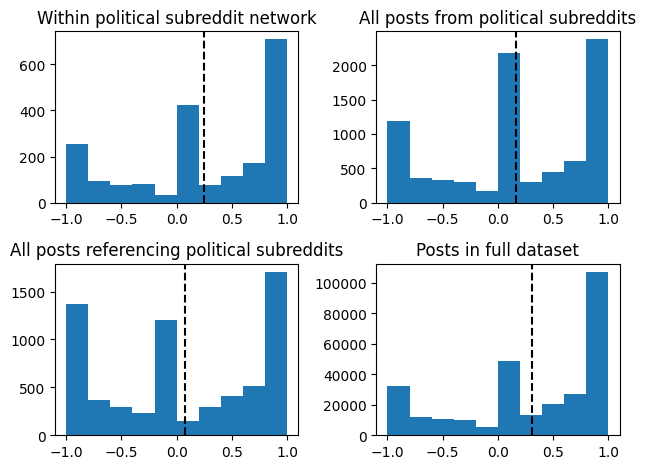

In [4]:
dfs = [df, df_psource, df_ptarget, df_full]

fig, axs = plt.subplots(2,2)

for ax, data in zip(axs.flatten(), dfs):
    ax.hist(data['sentiment_compound'])
    ax.axvline(np.mean(data['sentiment_compound']), linestyle='--', color='black')

axs[0][0].set_title("Within political subreddit network")
axs[0][1].set_title("All posts from political subreddits")
axs[1][0].set_title("All posts referencing political subreddits")
axs[1][1].set_title("Posts in full dataset")

plt.tight_layout()
plt.show()

### Post sentiments by louvain community
**When the political subreddits are the source post:**

Communities with more negative posts in dataset than positive: 
- Community 5 (ukpolitics)
- Community 7 (gunpolitics)
- Community 12 (europes)

Most neutral:
- Community 3 (worldpolitics)

All other communities have majority positive posts. 

----------------------------------------------


**When the political subreddits are the target post:**
- Many of the sentiment distributions shift to be more negative when political subreddits are the ones hyperlinked
- The exception to this are Community 5 and 12 (related to European politics) which show the opposite effect - the distribution shifts to be more positive.

NOTE: these are relatively small sample sizes when dividing by community.

			VADER SENTIMENT BY COMMUNITY 





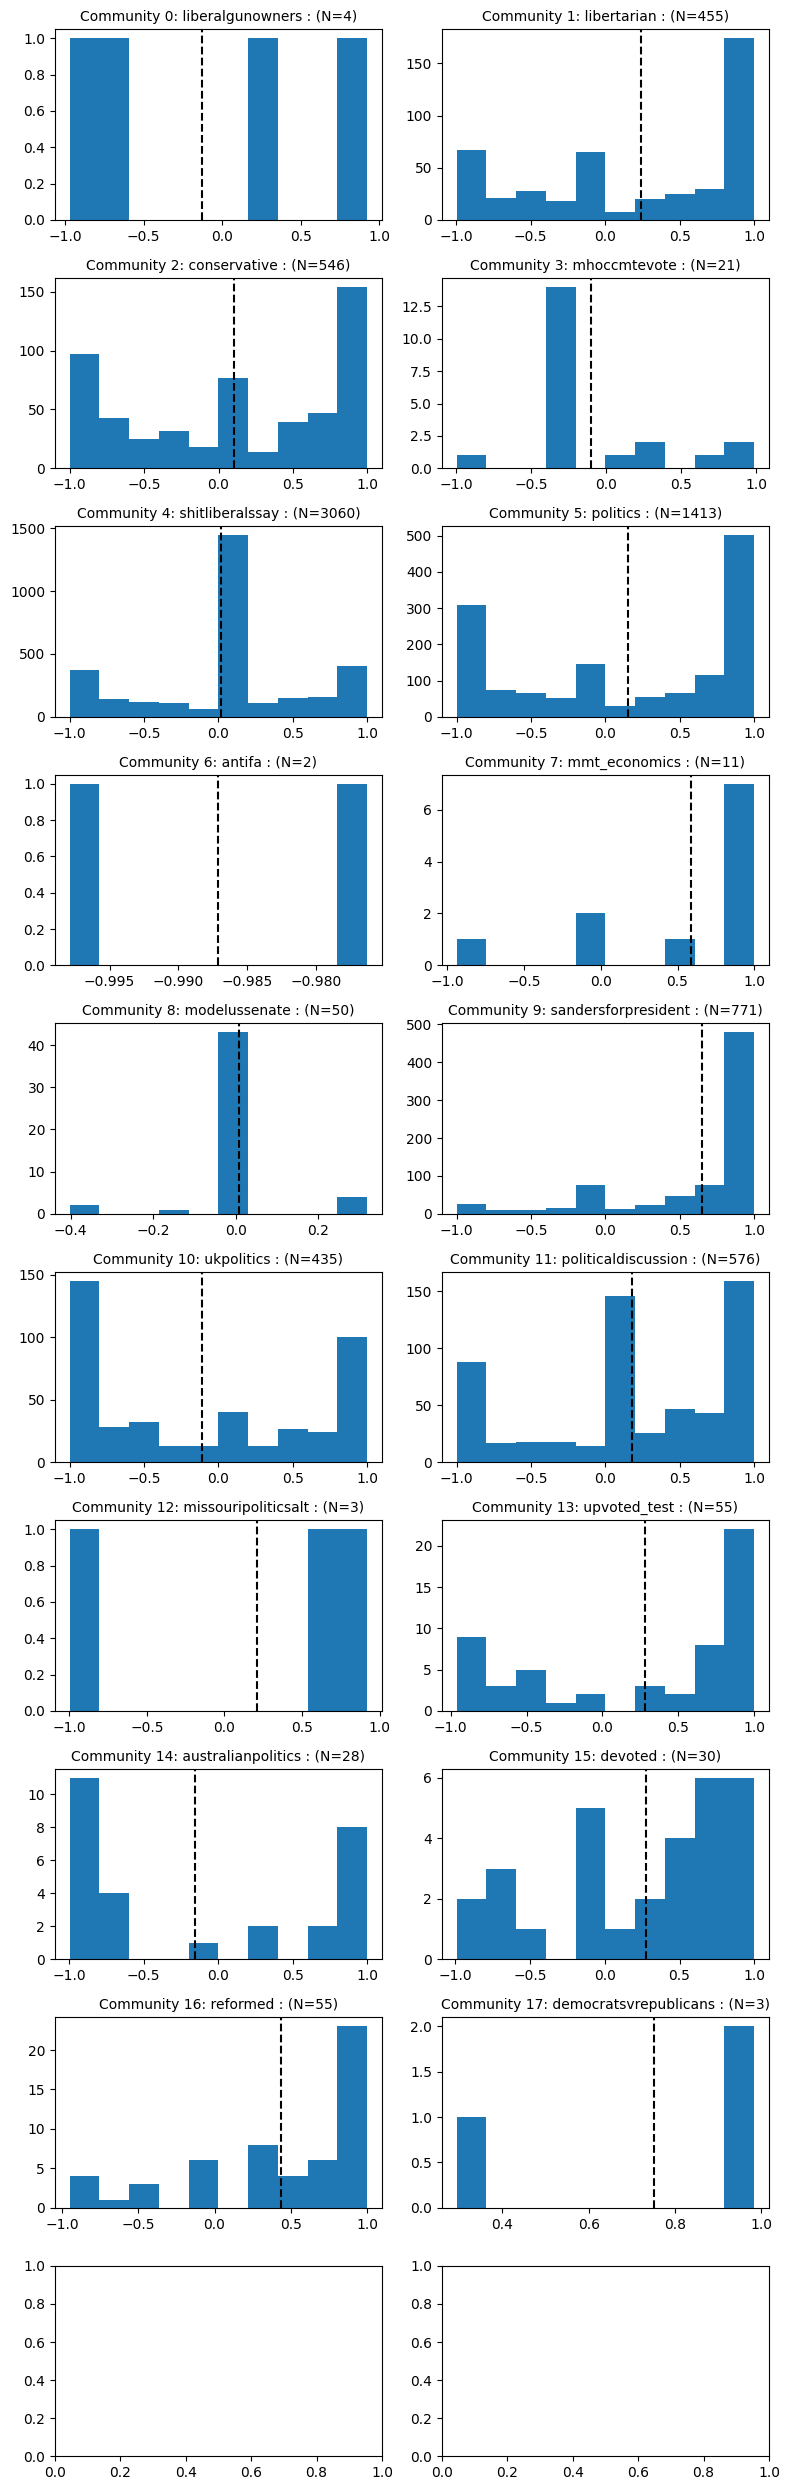

In [5]:
def plot_avg_sentiment(df, sentiment):
    fig, axs = plt.subplots(len(communities)//2 +1,2, figsize=(8,25))
    flat_ax = axs.flatten()
    
    for i, comm in enumerate(communities):
        idx_source = df[source].isin(comm)
        x_source = df[idx_source][f'sentiment_{sentiment}']
        flat_ax[i].hist(x_source)
        flat_ax[i].axvline(np.mean(x_source), linestyle='--', color="black")
        flat_ax[i].set_title(f'Community {i}: {community_labels[i][0]} : (N={len(x_source)})', fontdict={'fontsize': 10})
        ax.set_xlim([-1, 1])

    plt.tight_layout()
    plt.show()
    
print("\t\t\tVADER SENTIMENT BY COMMUNITY \n\n\n")

plot_avg_sentiment(df_full, 'compound')

## Hyperlink sentiments

In [6]:
253/(1780 + 253)
21070/(265491 + 21070)

0.07352710243194294

LINK_SENTIMENT
 1    1780
-1     253
Name: count, dtype: int64 


LINK_SENTIMENT
 1    7040
-1    1195
Name: count, dtype: int64 


LINK_SENTIMENT
 1    5618
-1     933
Name: count, dtype: int64 


LINK_SENTIMENT
 1    265491
-1     21070
Name: count, dtype: int64 




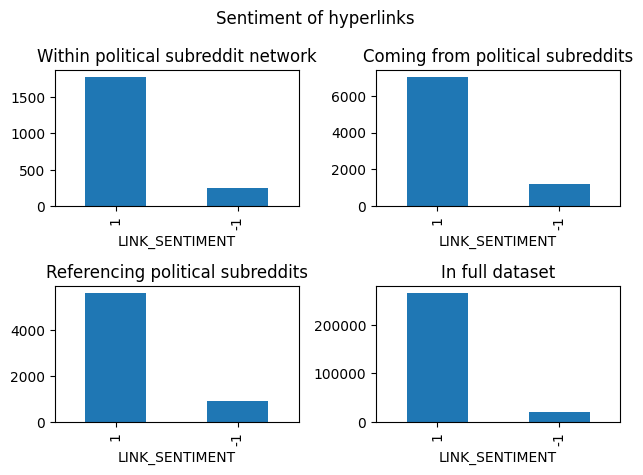

In [7]:
def sentiment_value_counts(df, ax):
    value_counts = df['LINK_SENTIMENT'].value_counts()
    print(value_counts, "\n\n")
    df['LINK_SENTIMENT'].value_counts().plot(kind='bar', ax=ax)
    
fig, axs = plt.subplots(2,2)

for ax, data in zip(axs.flatten(), [df, df_psource, df_ptarget, df_full]):
    sentiment_value_counts(data, ax)

axs[0][0].set_title("Within political subreddit network")
axs[0][1].set_title("Coming from political subreddits")
axs[1][0].set_title("Referencing political subreddits")
axs[1][1].set_title("In full dataset")
plt.suptitle("Sentiment of hyperlinks")
plt.tight_layout()
plt.show()

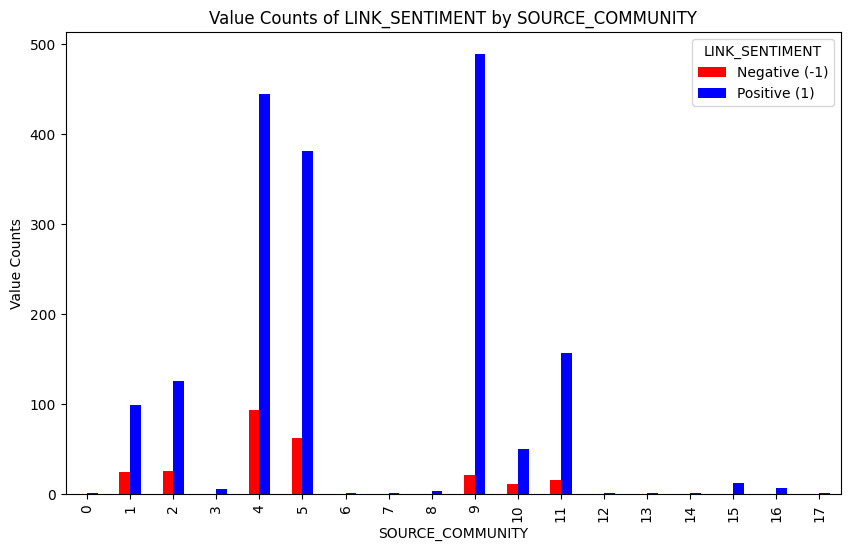

In [8]:
temp = df.groupby(by='SOURCE_COMMUNITY')['LINK_SENTIMENT'].value_counts()

temp = pd.Series(temp).unstack().fillna(0)  # Unstack to get LINK_SENTIMENT in columns
temp.index = temp.index.astype(int)  # Convert index to integers for sorting
temp = temp.sort_index()  # Sort by SOURCE_COMMUNITY for a cleaner plot
temp.plot(kind='bar', stacked=False, color=['red', 'blue'], figsize=(10, 6))
plt.xlabel('SOURCE_COMMUNITY')
plt.ylabel('Value Counts')
plt.title('Value Counts of LINK_SENTIMENT by SOURCE_COMMUNITY')
plt.legend(title='LINK_SENTIMENT', labels=['Negative (-1)', 'Positive (1)'])
plt.show()

## Networks by sentiment

### Political network graph

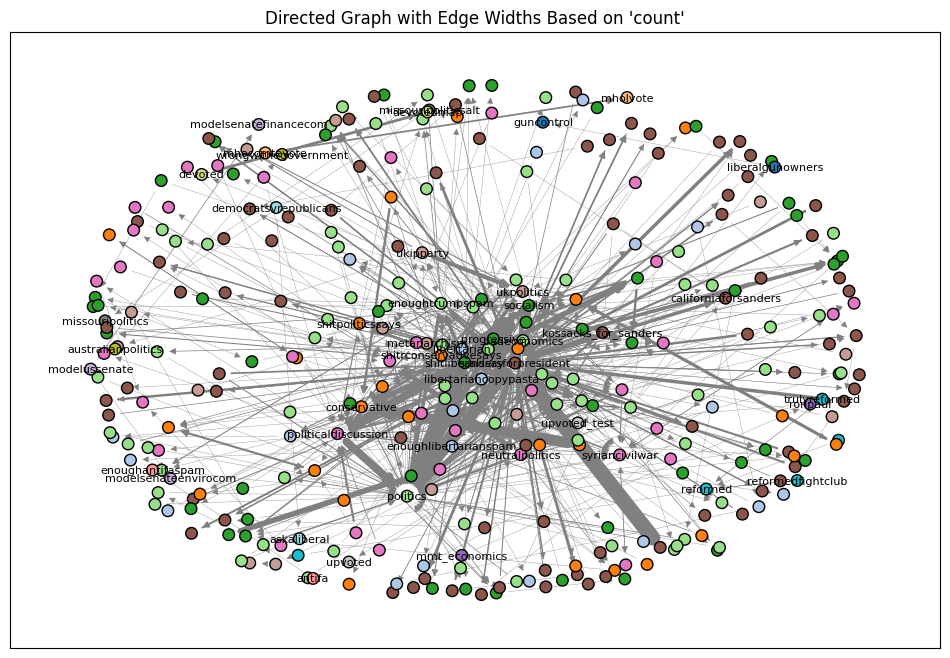

In [9]:
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
nodes = G_undirected.nodes()
node_color_list = [colors(G_undirected.nodes[n]['community']) for n in nodes]

pos = nx.spring_layout(G_directed, seed=42, k=0.5, scale=40)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_directed, pos, node_size=70, node_color=node_color_list, edgecolors="black")
nx.draw_networkx_labels(G_directed, label_pos, 
                        labels={node: node for node in sum(community_labels.values(),[])},
                        font_size=8, font_color="black")

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_directed.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_directed, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Directed Graph with Edge Widths Based on 'count'")
plt.show()

### Network of Negative Hyperlinks in Political Graph

In [10]:
# create graph from political network with negative edges
edgelist = df.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
negative_edges = edgelist[edgelist['LINK_SENTIMENT'] == -1]
negative_edges_df = negative_edges.drop_duplicates().copy()
negative_edges_df["count"] = negative_edges.groupby([source, target]).transform("size")
G_negative_edges = nx.from_pandas_edgelist(negative_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

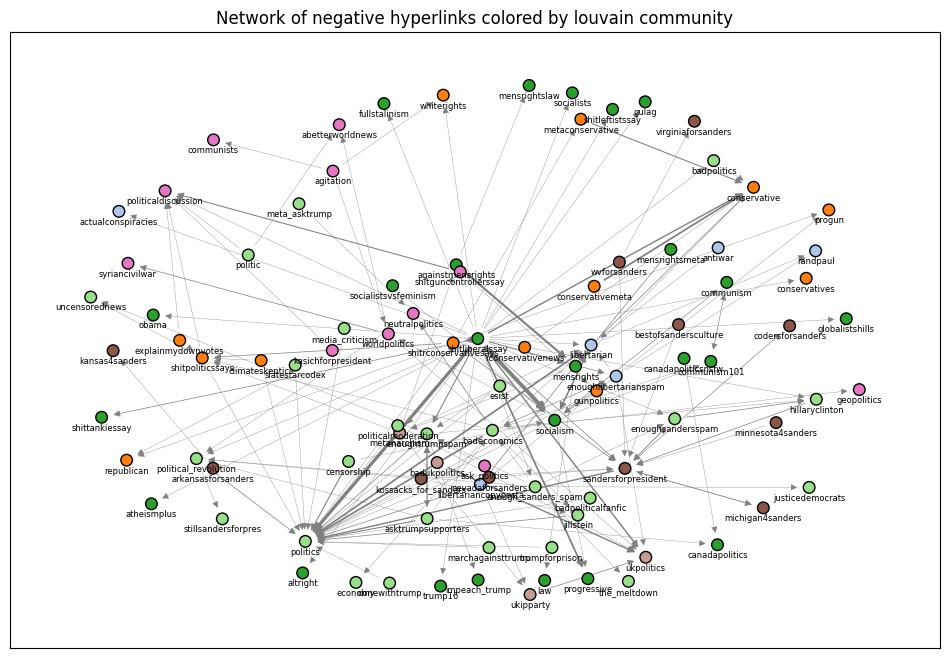

In [11]:
# Set up the plot
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i) 

# draw nodes with community colors
node_color_list = [node_colors.get(node, 'grey') for node in G_negative_edges.nodes()]

pos = nx.spring_layout(G_negative_edges, seed=42, k=0.5, scale=8)
label_pos = {node: (x, y - 0.3) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_negative_edges, pos, node_size=70, node_color=node_color_list, edgecolors="black")
nx.draw_networkx_labels(G_negative_edges, label_pos, 
                        labels={node: node for node in G_negative_edges.nodes},
                        font_size=6, font_color="black")

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_negative_edges.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_negative_edges, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Network of negative hyperlinks colored by louvain community")
plt.show()

### Network of positive hyperlinks in political network graph

In [12]:
# create graph from political network with positive edges
edgelist = df.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
positive_edges = edgelist[edgelist['LINK_SENTIMENT'] == 1]
positive_edges_df = positive_edges.drop_duplicates().copy()
positive_edges_df["count"] = positive_edges.groupby([source, target]).transform("size")
G_positive_edges = nx.from_pandas_edgelist(positive_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

In [13]:
top_pos_df = edgelist_df.sort_values("POSITIVE", ascending=False).iloc[:50,:]
most_connected = set(np.hstack((top_pos_df[source].unique(),top_pos_df[target].unique())))

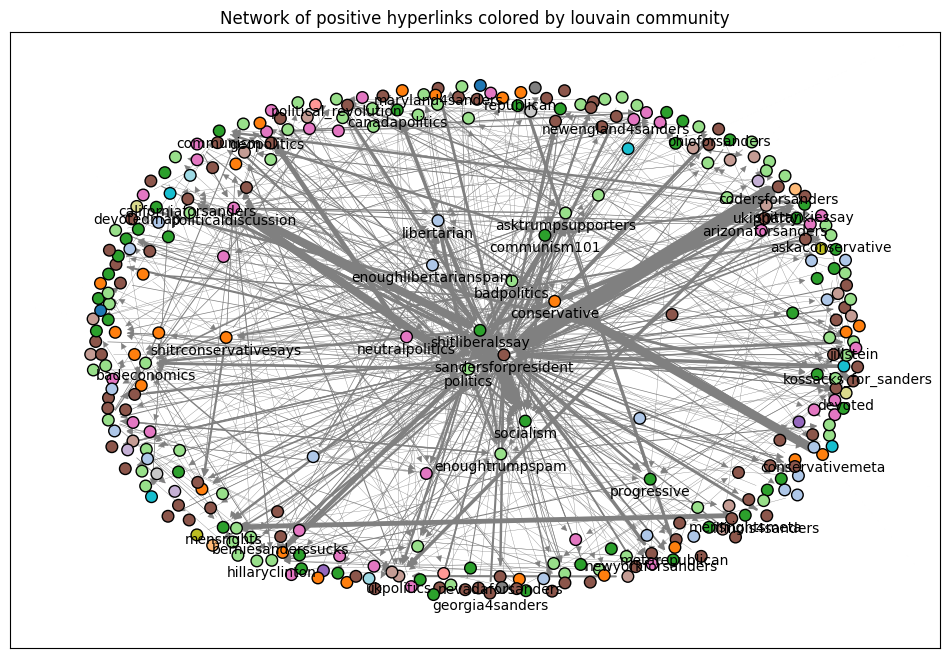

In [42]:
# Set up the plot
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i) 

# draw nodes with community colors
node_color_list = [node_colors.get(node, 'grey') for node in G_positive_edges.nodes()]

top_pos_df = edgelist_df.sort_values("POSITIVE", ascending=False).iloc[:50,:]
most_connected = set(np.hstack((top_pos_df[source].unique(),top_pos_df[target].unique())))

pos = nx.spring_layout(G_positive_edges, seed=42, k=1.2, scale=2)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_positive_edges, pos, node_size=70, node_color=node_color_list, edgecolors="black")
nx.draw_networkx_labels(G_positive_edges, label_pos, 
                        labels={node: node for node in most_connected},
                        font_size=10, font_color="black")

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_positive_edges.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_positive_edges, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Network of positive hyperlinks colored by louvain community")
plt.show()

### Network with all negative hyperlinks targeting political subs

In [15]:
# create graph from subreddits negatively linking a political sub
edgelist = df_ptarget.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
negative_edges = edgelist[edgelist['LINK_SENTIMENT'] == -1]
negative_edges_df = negative_edges.drop_duplicates().copy()
negative_edges_df["count"] = negative_edges.groupby([source, target]).transform("size")
G_nt = nx.from_pandas_edgelist(negative_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

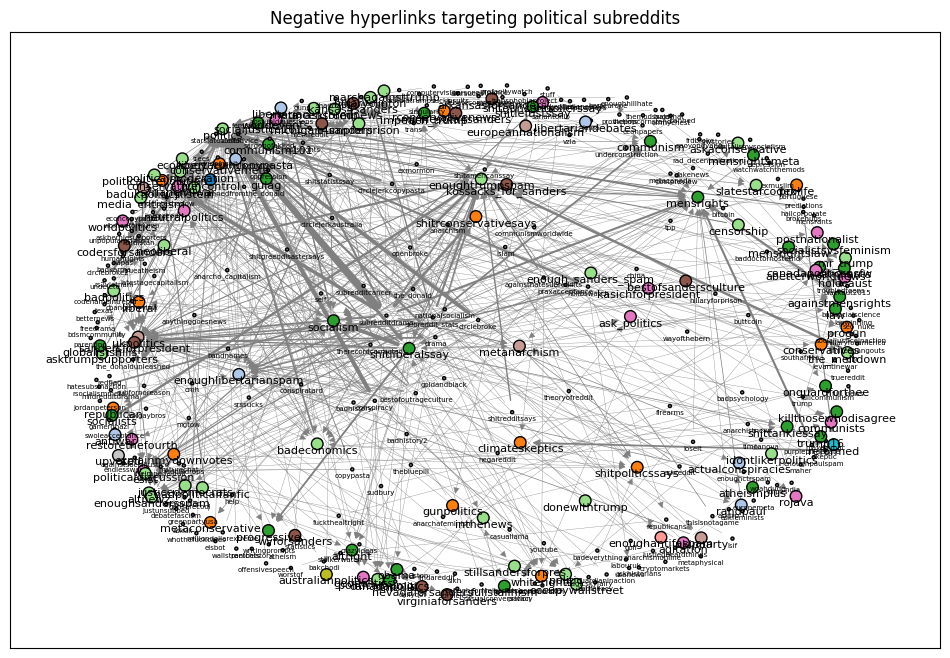

In [38]:
# Set up the plot
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i) 

# draw nodes with community colors
node_color_list = [node_colors.get(node, 'grey') for node in G_nt.nodes()]

node_sizes = [5 if color == 'grey' else 70 for color in node_color_list]
font_sizes = [5 if color == 'grey' else 8 for color in node_color_list]

pos = nx.spring_layout(G_nt, seed=42, k=0.8, scale=2)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_nt, pos, node_size=node_sizes, node_color=node_color_list, edgecolors="black")
# Define the positions and labels
labels = {node: node for node in G_nt.nodes()}

# Loop over nodes and draw each label with the appropriate font size
for i, (node, (x, y)) in enumerate(pos.items()):
    # Set font size based on node size
    font_size = 5 if node_sizes[i] == 5 else 8
    plt.text(x, y - 0.05, labels[node], fontsize=font_size, ha='center', va='center', color="black")
##

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_nt.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_nt, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Negative hyperlinks targeting political subreddits")
plt.show()

### Network with all positive hyperlinks targeting political subs

In [17]:
# create graph from subreddits positively linking a political sub
edgelist = df_ptarget.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
positive_edges = edgelist[edgelist['LINK_SENTIMENT'] == 1]
positive_edges_df = positive_edges.drop_duplicates().copy()
positive_edges_df["count"] = positive_edges.groupby([source, target]).transform("size")
G_pt = nx.from_pandas_edgelist(positive_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_40320/2964842713.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys')


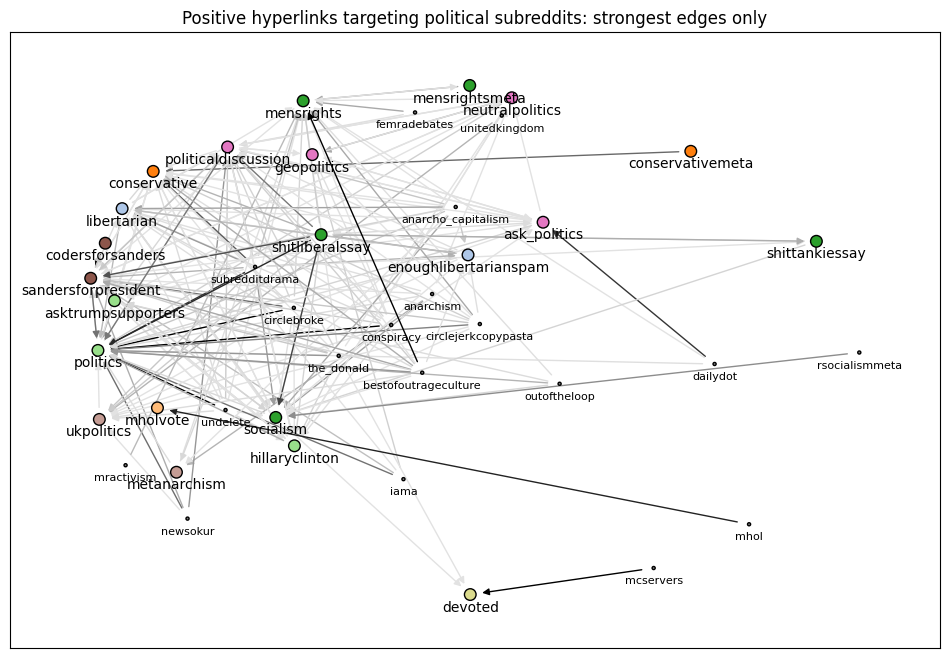

In [39]:
# Set up the plot
plt.figure(figsize=(12, 8))

# Define colors
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i)

# Filter out grey nodes (i.e., only keep nodes in the communities)
non_grey_nodes = [node for node in G_pt.nodes() if node in node_colors]

threshold = 10 
strong_edges = [(u, v, d) for u, v, d in G_pt.edges(data=True) if d['count'] > threshold]
strong_nodes = list(pd.DataFrame(strong_edges).drop(columns=2).stack().unique())

# Create a new graph with only the non-grey nodes and strong edges
G_filtered = G_pt.subgraph(strong_nodes).copy()
G_filtered.add_edges_from(strong_edges)

# Recompute positions for the filtered graph
pos = nx.spring_layout(G_filtered, seed=42, k=1.5, scale=5)

# Assign node colors and sizes for the filtered graph
node_color_list = [node_colors.get(node, 'grey') for node in G_filtered.nodes()]
node_sizes = [5 if color == 'grey' else 70 for color in node_color_list]
font_sizes = [5 if color == 'grey' else 8 for color in node_color_list]

# Define the positions and labels
labels = {node: node for node in G_filtered.nodes()}

# Draw nodes with community colors
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color=node_color_list, edgecolors="black")

# Loop over nodes and draw each label with the appropriate font size
for i, (node, (x, y)) in enumerate(pos.items()):
    font_size = 8 if node_sizes[i] == 5 else 10
    plt.text(x, y - 0.2, labels[node], fontsize=font_size, ha='center', va='center', color="black")

# # Edge widths related to count attribute (in the filtered graph)
# edge_widths = [d['count'] / 4 for (_, _, d) in G_filtered.edges(data=True)]

# # Draw edges with widths based on count
# nx.draw_networkx_edges(G_filtered, pos, edge_color="gray", arrows=True, width=edge_widths)

# Edge colors related to count attribute (gray to black gradient)
edge_counts = [d['count'] for (_, _, d) in G_filtered.edges(data=True)]
max_count = max(edge_counts)
min_count = min(edge_counts)

# Normalize edge weights for colormap
edge_colors = [(count - min_count) / (max_count - min_count) + 0.2 for count in edge_counts]

# Use a grayscale colormap for edges
cmap = plt.cm.get_cmap('Greys')

# Draw edges
nx.draw_networkx_edges(
    G_filtered, pos, 
    edge_color=[cmap(color) for color in edge_colors], 
    arrows=True, width=1  # Set a consistent width for better readability
)


# Set title and show plot
plt.title("Positive hyperlinks targeting political subreddits: strongest edges only")
plt.show()


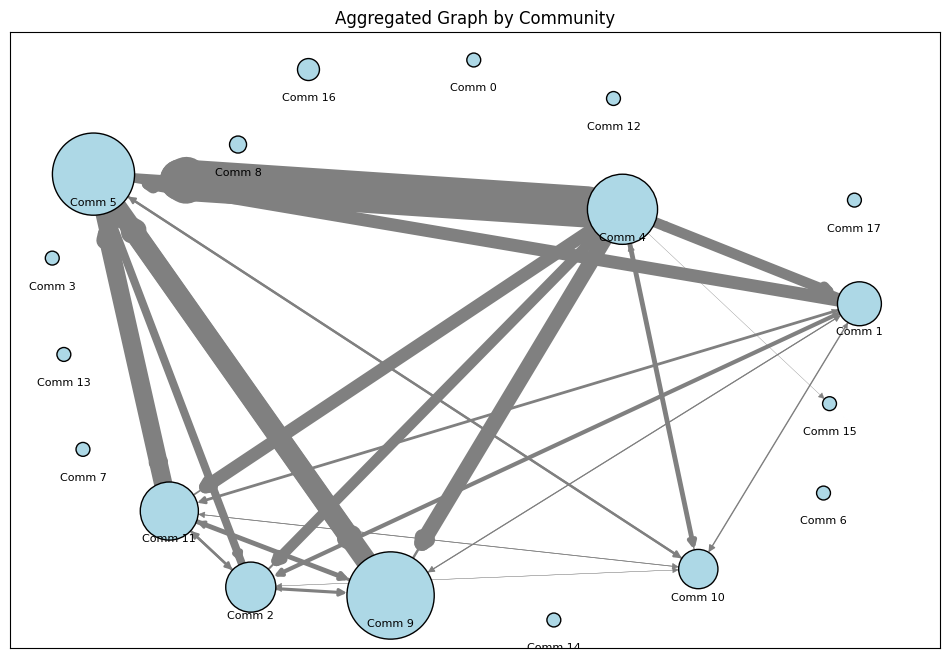

In [46]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new graph for aggregated communities
G_aggregated = nx.DiGraph()

# Map each node to its community index
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# Add aggregated nodes (one for each community)
for i in range(len(communities)):
    G_aggregated.add_node(i, size=len(communities[i]))

# Aggregate edges between communities
for u, v, data in G_directed.edges(data=True):
    weight = data.get('count', 1)  # Default to 1 if 'count' not specified
    u_comm = node_to_community[u]
    v_comm = node_to_community[v]
    if u_comm != v_comm:  # Ignore intra-community edges
        if G_aggregated.has_edge(u_comm, v_comm):
            G_aggregated[u_comm][v_comm]['weight'] += weight
        else:
            G_aggregated.add_edge(u_comm, v_comm, weight=weight)

# Visualize the aggregated graph
plt.figure(figsize=(12, 8))

# Define node colors and sizes
colors = plt.get_cmap('tab20', len(communities))
node_colors = [colors(i) for i in range(len(communities))]
node_sizes = [G_aggregated.nodes[n]['size'] * 50 for n in G_aggregated.nodes()]

# Define edge widths based on weights
edge_widths = [d['weight'] / 4 for (_, _, d) in G_aggregated.edges(data=True)]

# Layout and draw the graph
pos = nx.spring_layout(G_aggregated, seed=42, k=10, scale=1)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_aggregated, pos, node_size=node_sizes, node_color="lightblue", edgecolors="black")
nx.draw_networkx_labels(G_aggregated, label_pos, 
                        labels={node: f"Comm {node}" for node in G_aggregated.nodes()},
                        font_size=8, font_color="black")
nx.draw_networkx_edges(G_aggregated, pos, node_size=node_sizes, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Aggregated Graph by Community")
plt.show()


## Sentiment metrics

In [21]:
# MOST NEGATIVE LINKS: TARGET
idx_negative = df['LINK_SENTIMENT'] == -1
df.loc[idx_negative, [target, "LINK_SENTIMENT"]].value_counts(target)[:10]

TARGET_SUBREDDIT
politics               53
socialism              19
conservative           17
sandersforpresident    14
ukpolitics             13
mensrights             10
libertarian             9
enoughtrumpspam         9
politicaldiscussion     8
shitpoliticssays        6
Name: count, dtype: int64

In [22]:
# MOST POSITIVE LINKS: TARGET
idx_positive = df['LINK_SENTIMENT'] == 1
df.loc[idx_positive, [target, "LINK_SENTIMENT"]].value_counts(target)[:10]

TARGET_SUBREDDIT
sandersforpresident     405
politics                277
socialism                86
politicaldiscussion      85
conservative             72
libertarian              38
ukpolitics               35
hillaryclinton           29
geopolitics              28
political_revolution     27
Name: count, dtype: int64

In [23]:
# MOST NEGATIVE LINKS: SOURCE
idx_negative = df['LINK_SENTIMENT'] == -1
df.loc[idx_negative, [source, "LINK_SENTIMENT"]].value_counts(source)[:10]

SOURCE_SUBREDDIT
shitliberalssay          66
badeconomics             13
libertarian              12
asktrumpsupporters        9
sandersforpresident       9
socialism                 8
shitrconservativesays     8
againstmensrights         7
libertariancopypasta      6
enoughtrumpspam           6
Name: count, dtype: int64

In [24]:
# MOST POSITIVE LINKS: SOURCE
idx_positive = df['LINK_SENTIMENT'] == 1
df.loc[idx_positive, [source, "LINK_SENTIMENT"]].value_counts(source)[:10]

SOURCE_SUBREDDIT
shitliberalssay        273
sandersforpresident    160
asktrumpsupporters      45
codersforsanders        44
politicaldiscussion     42
libertarian             40
badeconomics            36
enoughtrumpspam         35
socialism               33
neutralpolitics         30
Name: count, dtype: int64

In [25]:
community_labels

{0: ['liberalgunowners', 'guncontrol'],
 1: ['libertarian', 'enoughlibertarianspam', 'libertariancopypasta'],
 2: ['conservative', 'shitrconservativesays', 'shitpoliticssays'],
 3: ['mhoccmtevote', 'mholvote'],
 4: ['shitliberalssay', 'socialism', 'progressive'],
 5: ['politics', 'enoughtrumpspam', 'badeconomics'],
 6: ['antifa', 'enoughantifaspam'],
 7: ['mmt_economics', 'ronpaul'],
 8: ['modelussenate', 'modelsenateenvirocom', 'modelsenatefinancecom'],
 9: ['sandersforpresident', 'kossacks_for_sanders', 'californiaforsanders'],
 10: ['ukpolitics', 'metanarchism', 'ukipparty'],
 11: ['politicaldiscussion', 'syriancivilwar', 'neutralpolitics'],
 12: ['missouripoliticsalt', 'missouripolitics'],
 13: ['upvoted_test', 'upvoted'],
 14: ['australianpolitics', 'wrongwithegovernment'],
 15: ['devoted', 'devotedmap'],
 16: ['reformed', 'trulyreformed', 'reformedfightclub'],
 17: ['democratsvrepublicans', 'askaliberal']}

In [47]:
df

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES,char_count,char_count_no_space,alpha_fraction,digit_fraction,...,LIWC_Home,LIWC_Money,LIWC_Relig,LIWC_Death,LIWC_Assent,LIWC_Dissent,LIWC_Nonflu,LIWC_Filler,SOURCE_COMMUNITY,TARGET_COMMUNITY
360,metaconservative,conservative,1uf4qp,2014-01-04 14:50:38,-1,"769.0,658.0,0.788036410923,0.00130039011704,0....",769.0,658.0,0.788036,0.001300,...,0.000000,0.000000,0.000000,0.023438,0.000000,0.007812,0.000000,0.007812,2,2
362,libertarian,conservative,1uf53xs,2014-01-04 14:41:05,1,"739.0,633.0,0.794316644114,0.00135317997294,0....",739.0,633.0,0.794317,0.001353,...,0.000000,0.000000,0.000000,0.024590,0.000000,0.008197,0.000000,0.008197,1,2
530,libertariancopypasta,politicaldiscussion,1ujbnhs,2014-01-06 12:33:49,1,"1643.0,1383.0,0.793061472915,0.00182592818016,...",1643.0,1383.0,0.793061,0.001826,...,0.003676,0.000000,0.000000,0.000000,0.003676,0.011029,0.000000,0.000000,1,11
547,communism101,communism,1ujok7s,2014-01-06 08:44:10,1,"608.0,525.0,0.792763157895,0.00164473684211,0....",608.0,525.0,0.792763,0.001645,...,0.010417,0.010417,0.000000,0.000000,0.000000,0.000000,0.010417,0.010417,4,4
962,mensrightsmeta,mensrights,1urzs0s,2014-01-15 11:33:58,1,"559.0,471.0,0.75313059034,0.00357781753131,0.0...",559.0,471.0,0.753131,0.003578,...,0.000000,0.000000,0.000000,0.019048,0.000000,0.000000,0.009524,0.009524,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285825,enough_sanders_spam,enoughsandersspam,67zs07,2017-04-27 17:34:00,-1,"783.0,681.0,0.757343550447,0.0204342273308,0.0...",783.0,681.0,0.757344,0.020434,...,0.000000,0.000000,0.008065,0.000000,0.008065,0.000000,0.000000,0.008065,5,5
285846,modelussenate,modelsenatefinancecom,68051ns,2017-04-27 18:44:31,1,"109.0,107.0,0.733944954128,0.0642201834862,0.0...",109.0,107.0,0.733945,0.064220,...,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8,8
285866,neoliberal,badeconomics,680xo6s,2017-04-27 21:36:40,1,"1506.0,1309.0,0.750332005312,0.0152722443559,0...",1506.0,1309.0,0.750332,0.015272,...,0.012500,0.079167,0.000000,0.000000,0.000000,0.000000,0.000000,0.008333,5,5
286055,devotedmap,devoted,685nnas,2017-04-28 17:39:18,1,"1570.0,1508.0,0.269426751592,0.373885350318,0....",1570.0,1508.0,0.269427,0.373885,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15,15


In [50]:
# NUMBER OF LINKS BETWEEN COMMUNITIES
links_df = df[['SOURCE_COMMUNITY','TARGET_COMMUNITY','LINK_SENTIMENT']].value_counts().reset_index()
links_df

,SOURCE_COMMUNITY,TARGET_COMMUNITY,LINK_SENTIMENT,count
0,9,9,1,418
1,5,5,1,245
2,4,4,1,213
3,4,5,1,100
4,2,2,1,88
...,...,...,...,...
86,5,10,-1,1
87,4,15,1,1
88,2,10,1,1
89,2,1,1,1


['0 (Size:2)', '1 (Size:20)', '2 (Size:26)', '3 (Size:2)', '4 (Size:51)', '5 (Size:70)', '6 (Size:2)', '7 (Size:2)', '8 (Size:3)', '9 (Size:79)', '10 (Size:16)', '11 (Size:35)', '12 (Size:2)', '13 (Size:2)', '14 (Size:2)', '15 (Size:2)', '16 (Size:5)', '17 (Size:2)']


Text(0, 0.5, 'Number of hyperlinks')

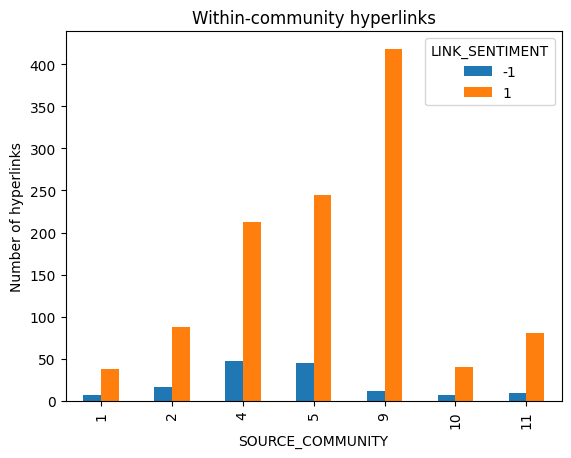

In [100]:
hyperlink_df = links_df.pivot_table(index=['SOURCE_COMMUNITY','TARGET_COMMUNITY'], 
                     columns='LINK_SENTIMENT', values='count', fill_value=0).reset_index()

## LINKS WITHIN COMMUNITIES
plot_df = hyperlink_df[hyperlink_df['SOURCE_COMMUNITY'] == hyperlink_df['TARGET_COMMUNITY']].reset_index()


xlabels = [f'{i} (Size:{len(c)})' for i, c in enumerate(communities)]
print(xlabels)
plot_df[plot_df[1] > 25].plot.bar(x="SOURCE_COMMUNITY", y=[-1,1]);
plt.title("Within-community hyperlinks")
plt.ylabel("Number of hyperlinks")

In [83]:
## Most negative links within themselves
plot_df['percent_negative'] = plot_df[-1]/(plot_df[-1] + plot_df[1])
plot_df[['SOURCE_COMMUNITY','percent_negative']].sort_values(by='percent_negative', ascending=False)

LINK_SENTIMENT,SOURCE_COMMUNITY,percent_negative
4,4,0.183908
2,2,0.161905
1,1,0.155556
5,5,0.155172
10,10,0.148936
11,11,0.100000
9,9,0.027907
12,12,0.000000
16,16,0.000000
15,15,0.000000


['0 (Size:2)', '1 (Size:20)', '2 (Size:26)', '3 (Size:2)', '4 (Size:51)', '5 (Size:70)', '6 (Size:2)', '7 (Size:2)', '8 (Size:3)', '9 (Size:79)', '10 (Size:16)', '11 (Size:35)', '12 (Size:2)', '13 (Size:2)', '14 (Size:2)', '15 (Size:2)', '16 (Size:5)', '17 (Size:2)']


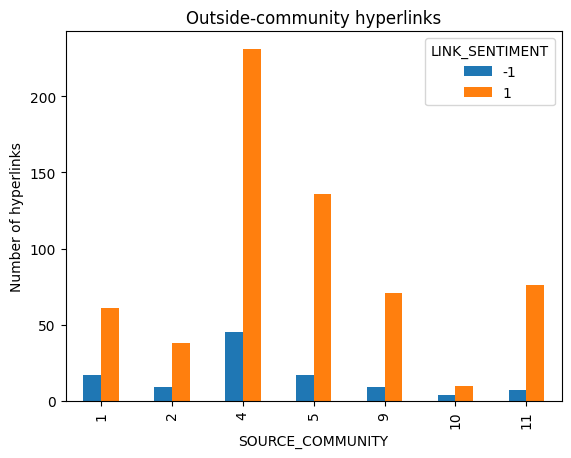

In [97]:
## LINKS OUTSIDE OF COMMUNITY
temp = hyperlink_df[~(hyperlink_df['SOURCE_COMMUNITY'] == hyperlink_df['TARGET_COMMUNITY'])].reset_index()

plot_df = temp.groupby(by='SOURCE_COMMUNITY')[[-1,1]].sum().reset_index()

xlabels = [f'{i} (Size:{len(c)})' for i, c in enumerate(communities)]
print(xlabels)
plot_df.plot.bar(x="SOURCE_COMMUNITY", y=[-1,1]);
plt.title("Outside-community hyperlinks")
plt.ylabel("Number of hyperlinks")
plt.show()

In [99]:
## Most negative links outside themselves
plot_df['percent_negative'] = plot_df[-1]/(plot_df[-1] + plot_df[1])
plot_df[['SOURCE_COMMUNITY','percent_negative']].sort_values(by='percent_negative', ascending=False).reset_index().drop(columns="index")

LINK_SENTIMENT,SOURCE_COMMUNITY,percent_negative
0,10,0.285714
1,1,0.217949
2,2,0.191489
3,4,0.163043
4,9,0.112500
5,5,0.111111
6,11,0.084337


In [120]:
within_comm_df = hyperlink_df[hyperlink_df['SOURCE_COMMUNITY'] == hyperlink_df['TARGET_COMMUNITY']].reset_index()


temp = hyperlink_df[~(hyperlink_df['SOURCE_COMMUNITY'] == hyperlink_df['TARGET_COMMUNITY'])].reset_index()

outside_comm_df = temp.groupby(by='SOURCE_COMMUNITY')[[-1,1]].sum().reset_index()

In [121]:
within_comm_df = within_comm_df[['SOURCE_COMMUNITY', -1,1]]
outside_comm_df = outside_comm_df[['SOURCE_COMMUNITY', -1,1]]
within_comm_df.columns = ['SOURCE_COMMUNITY', 'within(-1)', 'within(1)']
outside_comm_df.columns = ['SOURCE_COMMUNITY', 'outside(-1)', 'outside(1)']
merged_df = within_comm_df.merge(outside_comm_df, on='SOURCE_COMMUNITY', how='inner')
# merged_df.fillna(0, inplace=True)

,SOURCE_COMMUNITY,within(-1),within(1),outside(-1),outside(1)
0,1,7.0,38.0,17.0,61.0
1,2,17.0,88.0,9.0,38.0
2,4,48.0,213.0,45.0,231.0
3,5,45.0,245.0,17.0,136.0
4,9,12.0,418.0,9.0,71.0
5,10,7.0,40.0,4.0,10.0
6,11,9.0,81.0,7.0,76.0


In [123]:
merged_df[['SOURCE_COMMUNITY','within(1)','within(-1)','outside(1)','outside(-1)']].astype(int)

,SOURCE_COMMUNITY,within(1),within(-1),outside(1),outside(-1)
0,1,38,7,61,17
1,2,88,17,38,9
2,4,213,48,231,45
3,5,245,45,136,17
4,9,418,12,71,9
5,10,40,7,10,4
6,11,81,9,76,7


In [128]:
merged_df['within(%)'] = merged_df['within(-1)'] / (merged_df['within(1)'] + merged_df['within(-1)'])
merged_df['outside(%)'] = merged_df['outside(-1)'] / (merged_df['outside(1)'] + merged_df['outside(-1)'])

merged_df['within(%)'] - merged_df['outside(%)'] 

0   -0.062393
1   -0.029585
2    0.020865
3    0.044061
4   -0.084593
5   -0.136778
6    0.015663
dtype: float64

In [129]:
merged_df

,SOURCE_COMMUNITY,within(-1),within(1),outside(-1),outside(1),within(%),outside(%)
0,1,7.0,38.0,17.0,61.0,0.155556,0.217949
1,2,17.0,88.0,9.0,38.0,0.161905,0.191489
2,4,48.0,213.0,45.0,231.0,0.183908,0.163043
3,5,45.0,245.0,17.0,136.0,0.155172,0.111111
4,9,12.0,418.0,9.0,71.0,0.027907,0.112500
5,10,7.0,40.0,4.0,10.0,0.148936,0.285714
6,11,9.0,81.0,7.0,76.0,0.100000,0.084337
